In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 1.0
miu 0.045
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 225.0
Z 0.178
KI 15.0
K0 1.5
Ka 0.03
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 3.0
Smax 45.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.04
dNextindt 0.0
dmoutdt 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Weighing,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN


In [4]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')]
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [5]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [6]:
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [7]:
df2_Reduced[(df2_Reduced['T'] > 504)]

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
342,111.7,4,1,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.447,NaN,...,2.0,1.0,1000.0,168.0,1000.0,No,Time effect,NaN,NaN,505
343,112.7,4,2,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.504,NaN,...,2.0,1.0,1000.0,168.0,1000.0,No,Time effect,NaN,NaN,505
344,113.7,4,3,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.546,NaN,...,0.0,1.0,1000.0,168.0,1000.0,No,Time effect,NaN,NaN,505
366,114.7,4,4,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.390,NaN,...,2.0,2.0,500.0,168.0,1000.0,No,NaN,NaN,NaN,505
367,115.7,4,5,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.447,NaN,...,2.0,2.0,500.0,168.0,1000.0,No,NaN,NaN,NaN,505
368,116.7,4,6,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.423,NaN,...,0.0,2.0,500.0,168.0,1000.0,No,NaN,NaN,NaN,505
369,117.7,4,7,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.414,NaN,...,2.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,505
370,118.7,4,8,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.411,NaN,...,2.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,505
416,119.7,4,9,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.441,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,505



Treatment: 1000/1/168
Number of samples:
m: 49 Nint: 34 Next: 38
7.0
0.0
Starting point
168.0
Duration
336.0
Duration


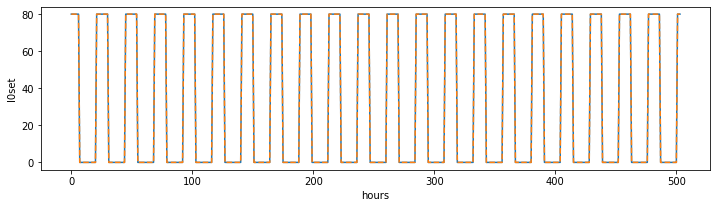

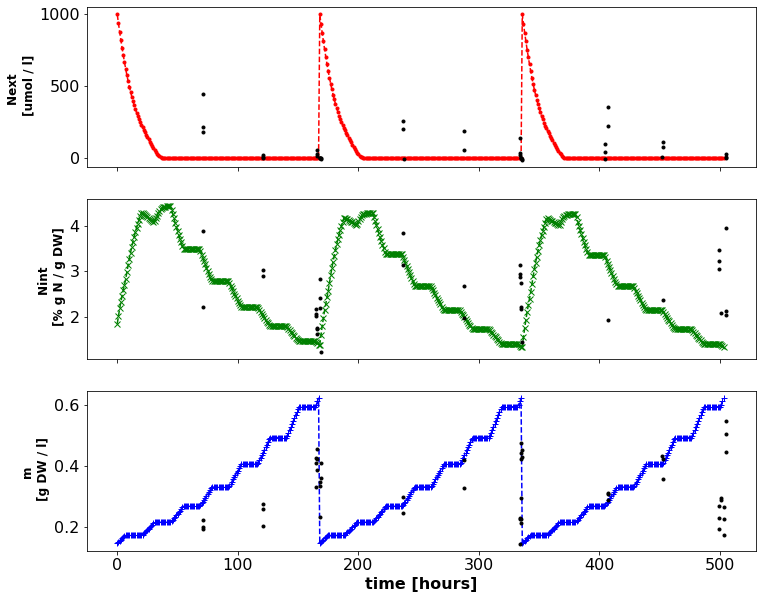

In [8]:
# model simulations and measured data for the different treatments - fix problem with time (x axis) in 1000/1/168
#miu = 0.05
#dNextoutdt = 0.01

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

for i in Treatments[:1]:
    print('\nTreatment: ' + str(i))
    df2Temp = df2_Reduced[(df2_Reduced.Treatment == i)]
    mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
    mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
    NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
    NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
    NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
    NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
    mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
    mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
    NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
    NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
    NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
    NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']
    print('Number of samples:\nm: ' + str(len(mTimeTemp)) + ' Nint: ' + str(len(NintTimeTemp)) + ' Next: ' + str(len(NextTimeTemp)))
    
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    # I0set[:100] = 80
    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    

    
 
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),
                   printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)
    
    TModAll.append(TT)
    mExpAllTimes.append(mTimeTemp)
    NintExpAllTimes.append(NintTimeTemp)
    NextExpAllTimes.append(NextTimeTemp)
    
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
        # Sanity check
    plt.figure(figsize=(12,3))
    plt.plot(all_treatment_hours,I0set,'-',t_model,I0(t_model),'--')
    plt.xlabel('hours')
    plt.ylabel('I0set')
    
    plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)

In [9]:
# This cell adjusts measurment time to model durations - so that maximum biomass measurements are compared to maximum biomass
# predictions and not to the initial stocking density (m0)

TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

for i in range(len(TModAll)):
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes[i]:
        #print(mExpAllTimes[i])
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        #print(j)
        mModReduced.append(gm(j-1))
    
    mModReducedAll.append(mModReduced)
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0


In [10]:
df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True) & (df2_Reduced.Treatment == i)]

In [11]:
mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Treatment == Treatments[i])]
    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample:
        mexp = df2m.DW
        mmod = mModReducedAll[i]
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)
    mSRE_All.append(mSRE)
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModReducedAll[i]
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)
    NintSRE_All.append(NintSRE)
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 49

Sample #1
Measured biomass: 0.408
Modeled biomass: 0.593

Sample #2
Measured biomass: 0.426
Modeled biomass: 0.593

Sample #3
Measured biomass: 0.33
Modeled biomass: 0.593

Sample #11
Measured biomass: 0.294
Modeled biomass: 0.61

Sample #12
Measured biomass: 0.213
Modeled biomass: 0.61

Sample #13
Measured biomass: 0.228
Modeled biomass: 0.61

Sample #21
Measured biomass: 0.267
Modeled biomass: 0.61

Sample #22
Measured biomass: 0.174
Modeled biomass: 0.61

Sample #23
Measured biomass: 0.228
Modeled biomass: 0.61

Sample #31
Measured biomass: 0.423
Modeled biomass: 0.6

Sample #32
Measured biomass: 0.387
Modeled biomass: 0.6

Sample #33
Measured biomass: 0.456
Modeled biomass: 0.6

Sample #41
Measured biomass: 0.231
Modeled biomass: 0.6

Sample #42
Measured biomass: 0.228
Modeled biomass: 0.6

Sample #43
Measured biomass: 0.147
Modeled biomass: 0.6

Sample #51
Measured biomass: 0.27
Modeled biomass: 0.593

Sample #52
Measured biomass: 0

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


IndexError: list index out of range

In [ ]:
mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Treatment == Treatments[i])]
    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample:
        mexp = df2m.DW
        mmod = mModReducedAll[i]
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)
    mSRE_All.append(mSRE)
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModReducedAll[i]
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)
    NintSRE_All.append(NintSRE)
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        #print('Sample #' + str(math.floor(float(j))))
        #print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        #print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:
mSRE_AllTemp = []
for i in range(len(mSRE_All)):
    for j in range(len(mSRE_All[i])):
        mSRE_AllTemp.append(mSRE_All[i][j])
RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)
print(RMSREm)

In [ ]:
NintSRE_AllTemp = []
for i in range(len(NintSRE_All)):
    for j in range(len(NintSRE_All[i])):
        NintSRE_AllTemp.append(NintSRE_All[i][j])
RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
print(RMSRENint)

In [ ]:
NextSRE_AllTemp = []
for i in range(len(NextSRE_All)):
    for j in range(len(NextSRE_All[i])):
        NextSRE_AllTemp.append(NextSRE_All[i][j])
RMSRENext = round((np.mean(NextSRE_AllTemp))**0.5,3)
print(RMSRENext)

In [ ]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined